In [1]:
!pip install librosa scikit-learn numpy pandas matplotlib
!pip install xgboost

!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [8]:
import os
import numpy as np
import pandas as pd
import librosa
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [10]:
# data_dir ='/Users/dkamboj6/Recitation/460j_fma_dataset/fma_small'
# # directory_path = '/Users/dkamboj6/Recitation/460j_fma_dataset/fma_small/000'
# file_path='/Users/dkamboj6/Recitation/460j_fma_dataset/fma_small/000/000002.mp3'
# meta_dir='/Users/dkamboj6/Recitation/460j_fma_dataset/fma_metadata'


In [14]:
data_dir="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small"
file_path="C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_small/000/000002.mp3"

In [12]:
# Paths to the datasets
# tracks_path = '/Users/dkamboj6/Recitation/460j_fma_dataset/fma_metadata/tracks.csv'
# genres_path = '/Users/dkamboj6/Recitation/460j_fma_dataset/fma_metadata/genres.csv'
tracks_path=f"C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_metadata/tracks.csv"
genres_path= f"C:/Users/divya/OneDrive/Documents/UTAUSTIN/Semester 6/460j/final_project_data/fma_metadata/genres.csv"
# Load data
tracks = pd.read_csv(tracks_path, index_col=0, header=[0, 1])
genres = pd.read_csv(genres_path)

# List to hold feature arrays and genre labels

genre_list = []

# Read tracks metadata
tracks = pd.read_csv(tracks_path, index_col=0, header=[0, 1])
track_genres = tracks['track', 'genre_top']
print(tracks.head())
print(genres.head())

            album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                      

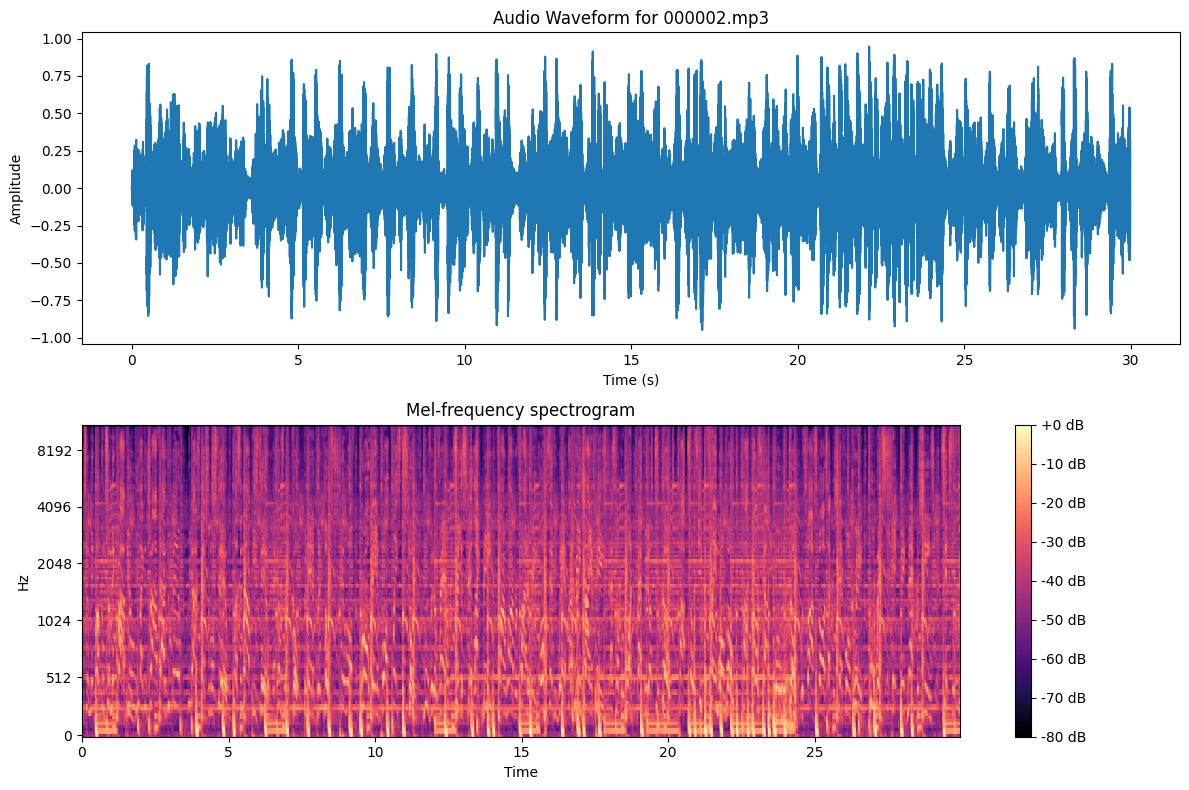

In [15]:
def plot_audio(file_path):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path)
    
    # Plot the audio waveform
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
    plt.title(f'Audio Waveform for {os.path.basename(file_path)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Generate and display a spectrogram
    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    
    plt.tight_layout()
    plt.show()

# Directory containing the audio files

plot_audio(file_path)
# # Loop through all files in the directory and plot them if they are mp3 files
# for filename in os.listdir(directory_path):
#     if filename.endswith('.mp3'):
#         file_path = os.path.join(directory_path, filename)
#         print(f"Plotting {filename}")
#         plot_audio(file_path)


In [80]:

def extract_features(file_path):
    try:
        # Load audio file
        y, sr = librosa.load(file_path, sr=None)
        
        # Get the Mel-frequency cepstral coefficients
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_processed = np.mean(mfcc.T,axis=0)
        
        # Get the spectral contrast
        stft = np.abs(librosa.stft(y))
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
        contrast_processed = np.mean(contrast.T,axis=0)
        
        # Get the chroma feature
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_processed = np.mean(chroma.T,axis=0)
        
        # Get the mel-scaled spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_processed = np.mean(mel.T,axis=0)

        # Concatenate all features into one array
        features = np.hstack([mfccs_processed, contrast_processed, chroma_processed, mel_processed])
        
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, error: {e}")
        return None 
    
    return features


In [81]:
features_list = []


In [82]:
def process_all_audio_files(base_directory):
    features_list = []
    track_ids = []

    # Walk through all files in the directory structure
    for subdir, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.mp3'):
                file_path = os.path.join(subdir, file)
                features = extract_features(file_path)
                if features is not None:
                    features_list.append(features)
                    # Extract track ID from filename
                    track_id = int(file.split('.')[0])
                    track_ids.append(track_id)

    return features_list, track_ids

In [83]:

# Process all audio files and collect features
features, track_ids = process_all_audio_files(data_dir)

# Optionally, load the metadata and merge it with the extracted features
tracks_path = '/Users/dkamboj6/Recitation/460j_fma_dataset/fma_metadata/tracks.csv'
tracks = pd.read_csv(tracks_path, index_col=0, header=[0, 1])
track_genres = tracks['track', 'genre_top']

# Create DataFrame
features_df = pd.DataFrame(features, index=track_ids)
features_df['genre'] = features_df.index.map(track_genres.get)

[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...
/var/folders/1b/1s1wkrq567qbcsjbr2nqkyw40000gn/T/ipykernel_37401/538791090.py:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
/Users/dkamboj6/Recitation/460jFinalProject/.venv/lib/python3.10/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error encountered while parsing file: /Users/dkamboj6/Recitation/460j_fma_dataset/fma_small/133/133297.mp3, error: 


[src/libmpg123/layer3.c:INT123_do_layer3():1773] error: part2_3_length (3360) too large for available bit count (3240)
[src/libmpg123/layer3.c:INT123_do_layer3():1773] error: part2_3_length (3328) too large for available bit count (3240)
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 33361.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1365] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 63168.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123

Error encountered while parsing file: /Users/dkamboj6/Recitation/460j_fma_dataset/fma_small/099/099134.mp3, error: 


/Users/dkamboj6/Recitation/460jFinalProject/.venv/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
[src/libmpg123/parse.c:do_readahead():1099] warning: Cannot read next header, a one-frame stream? Duh...


Error encountered while parsing file: /Users/dkamboj6/Recitation/460j_fma_dataset/fma_small/108/108925.mp3, error: 


[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


In [89]:
output_path = '/Users/dkamboj6/Recitation/460JFINALPROJECT/extracted_features.csv'
features_df.to_csv(output_path)

print(f"Features saved to {output_path}")

Features saved to /Users/dkamboj6/Recitation/460JFINALPROJECT/extracted_features.csv


In [87]:
display(features_df.head())

,0,1,2,3,4,5,6,7,8,9,...,151,152,153,154,155,156,157,158,159,genre
135054,-332.698212,164.180786,-2.206706,33.989197,25.107168,-1.123998,22.071981,4.160213,2.123890,18.207983,...,1.642379e-07,1.595749e-07,1.549034e-07,1.514247e-07,1.478835e-07,1.451977e-07,1.430242e-07,1.415022e-07,1.400595e-07,Experimental
135336,-150.873749,139.642151,2.595671,42.941765,-4.488908,31.695967,-10.588540,9.824882,-5.275760,0.016601,...,2.407155e-06,2.619200e-09,2.641834e-09,2.812807e-09,2.634792e-09,2.891871e-09,2.527148e-09,2.790371e-09,2.567869e-09,Pop
135337,-142.289398,123.294418,-11.327998,8.333095,-26.330225,14.096824,-41.815739,-1.962893,-26.874327,3.128989,...,4.297333e-02,2.847299e-02,1.685413e-03,1.173045e-06,1.139617e-06,1.113150e-06,1.092298e-06,1.077361e-06,1.068209e-06,Pop
135043,-194.602676,153.645279,-8.672044,48.209267,-2.377492,22.750629,-10.435005,16.964609,3.652935,-12.159806,...,4.335489e-04,4.205281e-04,3.707072e-04,2.083087e-04,1.684870e-04,1.405511e-04,1.000405e-04,6.326493e-05,4.539177e-05,Folk
135091,-419.975494,78.255760,-52.299126,-23.445887,-58.448624,-33.137733,-47.827900,-20.992649,15.408698,42.180733,...,1.597196e-05,6.134692e-06,1.941509e-06,5.201682e-07,8.656790e-08,9.584634e-09,8.885087e-10,5.901100e-10,5.686094e-10,Experimental


In [19]:
#discrete fourier transform

import os
import librosa
import numpy as np
import pandas as pd

def extract_dft_features(file_path):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, sr=None)
        # Compute the DFT using librosa
        dft = np.abs(librosa.stft(audio))
        # Average over time to collapse the feature to one vector per file
        dft_features = np.mean(dft, axis=1)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, error: {e}")
        return None
    return dft_features

def process_audio_files_discrete(base_directory):
    features_list = []
    track_ids = []

    # Walk through all files in the directory structure
    for subdir, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith('.mp3'):
                file_path = os.path.join(subdir, file)
                features = extract_dft_features(file_path)
                if features is not None:
                    features_list.append(features)
                    # Extract track ID from filename
                    track_id = int(file.split('.')[0])
                    track_ids.append(track_id)

    return features_list, track_ids




In [20]:
# Define your base directory containing MP3 files

# Process all audio files and collect DFT features
dft_features, track_ids = process_audio_files_discrete(data_dir)

KeyboardInterrupt: 

In [ ]:
display(dft_features)

[]

In [ ]:
# Convert features and track IDs into a DataFrame
features_df_features = pd.DataFrame(dft_features, index=track_ids)
features_df_features.index.name = 'track_id'

# Save to CSV
output_path = '/Users/dkamboj6/Recitation/460j_fma_dataset/dft_features.csv'
features_df.to_csv(output_path)

print(f"DFT features saved to {output_path}")


XGboost baseline

In [121]:
features_df= pd.read_csv('/Users/dkamboj6/Recitation/460JFINALPROJECT/extracted_features.csv')

In [112]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [122]:
encoder = LabelEncoder()

y_encoded = encoder.fit_transform(features_df['genre'])
X = features_df.drop('genre', axis=1)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test)

# Compute AUC for each class and average
auc_scores = []
for i in range(len(encoder.classes_)):
    class_auc = roc_auc_score(y_test == i, y_pred_prob[:, i])
    auc_scores.append(class_auc)
average_auc = np.mean(auc_scores)

print("AUC Scores per class: ", auc_scores)
print("Average AUC: ", average_auc)

AUC Scores per class:  [0.9058245209855543, 0.8659500680971579, 0.9272361132782024, 0.930208365277329, 0.9328098325523955, 0.9319817710365881, 0.8147599462438331, 0.9002226558123902]
Average AUC:  0.9011241591604313


In [114]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.5, 1, 1.5, 2]
}


In [123]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Create an XGBoost classifier model instance
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings that are sampled
    scoring='roc_auc_ovr',  # Use one-vs-rest AUC score for multi-class classification
    cv=3,  # Number of folds in cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Perform the random search
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=1.0; total time=  26.8s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=1.0; total time=  27.0s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.2, max_depth=8, n_estimators=200, subsample=1.0; total time=  27.2s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  37.5s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  37.9s
[CV] END colsample_bytree=0.7, gamma=2, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=  38.1s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0; total time=  48.0s
[CV] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=6, n_estimators=200, subsample=1.0; total time=  48.1s
[CV]

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.5, 1, 1.5, 2],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='roc_auc_ovr', verbose=2)

In [124]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

# Optionally, use the best model found for further predictions or analysis
best_model = random_search.best_estimator_


Best parameters: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.5}
Best score: 0.8866868098122591


In [125]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **random_search.best_params_)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = model.predict_proba(X_test)

# Compute AUC for each class and average
auc_scores = []
for i in range(len(encoder.classes_)):
    class_auc = roc_auc_score(y_test == i, y_pred_prob[:, i])
    auc_scores.append(class_auc)
average_auc = np.mean(auc_scores)

print("AUC Scores per class: ", auc_scores)
print("Average AUC: ", average_auc)

AUC Scores per class:  [0.9074742549966403, 0.8728950762597976, 0.93286052816352, 0.930682512461107, 0.9346191565871199, 0.9363330471507488, 0.8337843078893489, 0.8994968071996714]
Average AUC:  0.9060182113384943


using existing features.csv

In [92]:
features_path = '/Users/dkamboj6/Recitation/460j_fma_dataset/fma_metadata/features.csv'
features_df = pd.read_csv(features_path, index_col=0)

/var/folders/1b/1s1wkrq567qbcsjbr2nqkyw40000gn/T/ipykernel_37401/1511657443.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,2

In [94]:
display(features_df)


,chroma_cens,chroma_cens.1,chroma_cens.2,chroma_cens.3,chroma_cens.4,chroma_cens.5,chroma_cens.6,chroma_cens.7,chroma_cens.8,chroma_cens.9,...,tonnetz.39,tonnetz.40,tonnetz.41,zcr,zcr.1,zcr.2,zcr.3,zcr.4,zcr.5,zcr.6
feature,,,,,,,,,,,,,,,,,,,,,
statistics,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,kurtosis,...,std,std,std,kurtosis,max,mean,median,min,skew,std
number,01,02,03,04,05,06,07,08,09,10,...,04,05,06,01,01,01,01,01,01,01
track_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.1806526184e+00,5.2303090096e+00,2.4932080507e-01,1.3476201296e+00,1.4824777842e+00,5.3137123585e-01,1.4815930128e+00,2.6914546490e+00,8.6686819792e-01,1.3412306309e+00,...,5.4125156254e-02,1.2225749902e-02,1.2110591866e-02,5.7588901520e+00,4.5947265625e-01,8.5629448295e-02,7.1289062500e-02,0.0000000000e+00,2.0898721218e+00,6.1448108405e-02
3,1.8889633417e+00,7.6053929329e-01,3.4529656172e-01,2.2952005863e+00,1.6540306807e+00,6.7592434585e-02,1.3668476343e+00,1.0540937185e+00,1.0810308903e-01,6.1918509007e-01,...,6.3831120729e-02,1.4211839065e-02,1.7740072682e-02,2.8246941566e+00,4.6630859375e-01,8.4578499198e-02,6.3964843750e-02,0.0000000000e+00,1.7167237997e+00,6.9330163300e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,-0.490129,0.463834,2.32197,-0.084352,1.662914,2.115189,-0.237794,5.695442,0.830353,1.951819,...,0.12841,0.022547,0.019816,4.448255,0.172852,0.028773,0.02832,0.003906,0.955388,0.012385
155317,-0.461559,-0.229601,-0.496632,-0.422033,0.130612,-0.263825,-0.628103,-0.082687,-0.229483,-0.492753,...,0.132964,0.023548,0.026527,3.270612,0.196289,0.031116,0.027832,0.002441,1.28306,0.019059
155318,0.552473,-0.110498,-0.532014,0.263131,-0.224011,-0.530972,1.713526,1.418444,1.325197,0.120333,...,0.108324,0.01754,0.020471,2.356727,0.212891,0.03845,0.037109,0.003418,0.828569,0.017904


Neural network

In [126]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [135]:
# Assuming X_train and X_test are DataFrames or Series from a DataFrame
X_train_np = X_train.values  # Convert DataFrame to numpy array
X_test_np = X_test.values  # Convert DataFrame to numpy array

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

# If y_train and y_test are pandas Series, convert them as well
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [132]:
print("Number of samples in features:", X_train_tensor.shape[0])
print("Number of labels:", y_train_tensor.shape[0])

print("Number of samples in test features:", X_test_tensor.shape[0])
print("Number of test labels:", y_test_tensor.shape[0])

Number of samples in features: 2
Number of labels: 1
Number of samples in test features: 2
Number of test labels: 1


In [133]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # You can tune this during hyperparameter optimization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

TypeError: 'int' object is not callable

Neural network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GenreClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GenreClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Example model initialization
input_size = X_train.shape[1]
hidden_size = 50  # This can be tuned
output_size = len(np.unique(y_encoded))
model = GenreClassifier(input_size, hidden_size, output_size)


In [ ]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
        
        # Validation loss
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += criterion(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        print(f'Epoch: {epoch+1}, Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

# Set loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be tuned
